In [1]:
import re
import pickle
import string
from urllib.parse import unquote, quote_plus
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['legend.fontsize'] = 14
%matplotlib inline

import nltk
from nltk.chunk import ne_chunk
from nltk.tokenize import word_tokenize
from nltk.corpus import words as nltk_words
from nltk.tag import StanfordNERTagger

from scipy.stats import skew as spskew
from scipy.stats import kurtosis as spkurt
from sklearn.preprocessing import minmax_scale, scale


In [2]:
df = pd.read_hdf('song-lyrics-genres-reviews.h5', key='df', mode='r')

# Vocabulary

In [3]:
english_words = set(nltk_words.words())

In [4]:
bands = sorted(set(df.band))
df_bands = pd.DataFrame(index=np.arange(len(bands)), columns=['band', 'lyrics_raw', 'lyrics', 'words', 'genres', 'reviews'])
for i, band in enumerate(bands):
    lyrics_raw = []
    df_band = df[df.band == band]
    genres = df_band.genres.iloc[0]
    songs = df_band.lyrics.values
    reviews = df_band.reviews.values[0]
    for song in songs:
        lyrics_raw += song
    lyrics_processed = ' '.join([re.sub(r"[^\w\d'\s]+", '', word) for line in lyrics_raw for word in line.split()])
    words = lyrics_processed.split()
#     words = [word for word in words if word.lower() in english_words]
    df_bands.iloc[i] = dict(band=band, lyrics_raw=lyrics_raw, lyrics=lyrics_processed, words=words, genres=genres, reviews=reviews)

def pct_english(x):
    return len(set(x).intersection(english_words)) / len(set(x))
num_english_words = df_bands.words.apply(pct_english)
df_bands = df_bands[num_english_words > 0.5]
df_bands['words'] = df_bands.words.apply(lambda x: [word for word in x if word.lower() in english_words])

# df_bands = df_bands[df_bands.words.apply(len) > 1000]
df_bands['N'] = df_bands.words.apply(len)
df_bands['V'] = df_bands.words.apply(lambda x: len(set(x)))
N = df_bands.N
V = df_bands.V
df_bands['TTR'] = V / N
df_bands['rootTTR'] = V / np.sqrt(N)
df_bands['logTTR'] = np.log(V) / np.log(N)
df_bands['corrTTR'] = V / np.sqrt(2 * N)
df_bands['dugast'] = (np.log(N))**2 / (np.log(N) - np.log(V))

# df_bands = df_bands[
#     (df_bands.word_count > df_bands.word_count.median()) &
#     (df_bands.reviews > df_bands.reviews.median())
# ]

print(df_bands.shape)

(548, 13)


# Genres
* Drop genre tags that never appear alone.
* Split genre tags into binary columns

In [5]:
top_genres = []
for i, item in df_bands.genres.iteritems():
    if len(item) == 1:
        top_genres.append(item[0])
top_genres = sorted(set(top_genres))
df_bands.genres = df_bands.genres.apply(lambda x: [i for i in x if i in top_genres])
for genre in top_genres:
    df_bands['genre_' + genre] = df_bands.genres.apply(lambda x: genre in x).astype(int)

In [6]:
df_bands.to_hdf('band-lyrics.h5', key='df', mode='w')

D:\Anaconda3\envs\metallyrics\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['band', 'lyrics_raw', 'lyrics', 'words', 'genres', 'reviews']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [7]:
df_bands[['band', 'lyrics', 'genres', 'reviews', 'N', 'V']].sort_values('N')[::-1]

,band,lyrics,genres,reviews,N,V
312,helloween,You're hanging around and got nuthin' to do Yo...,"[power, speed]",189,47020,3306
531,rage,Oh no Somebody said they're marching out tonig...,"[heavy, power, speed]",86,43490,3104
496,overkill,Riding the wind on a stormy night Rides a moth...,[thrash],199,40474,3595
564,saxon,Far below the valleys Hidden deep beneath the ...,"[heavy, nwobhm]",116,39693,2881
422,metallica,No life till leather We are gonna kick some as...,"[heavy, thrash]",295,35381,3317
...,...,...,...,...,...,...
216,earth,Bones are feeling sleazy Head spinning around ...,[doom],42,283,114
397,lustre,In dark serenity I sense waves Of timeless exi...,[black],17,282,175
374,kratornas,Satan Perpetual This is the land you will rule...,"[black, grindcore]",8,241,132
345,interment,The dead will arise Like an angel sent from he...,[death],8,178,83


In [8]:
df_bands[['band', 'lyrics', 'genres', 'reviews', 'N', 'V']].sort_values('V')[::-1]

,band,lyrics,genres,reviews,N,V
583,skyclad,O come ye young of Hamlynyou who know my tune ...,[folk],61,33743,4583
414,megadeth,Your bodies empty now As I hold you Now your g...,"[heavy, speed, thrash]",339,31771,3858
252,exhumed,Gurgling oblique aponeurosis is split As I inf...,"[death, grindcore]",33,17138,3688
588,slayer,Blasting our way through the boundaries of Hel...,[thrash],247,24160,3623
496,overkill,Riding the wind on a stormy night Rides a moth...,[thrash],199,40474,3595
...,...,...,...,...,...,...
397,lustre,In dark serenity I sense waves Of timeless exi...,[black],17,282,175
374,kratornas,Satan Perpetual This is the land you will rule...,"[black, grindcore]",8,241,132
73,avsky,I draw my strength from knowledge and hate A k...,[black],9,168,119
216,earth,Bones are feeling sleazy Head spinning around ...,[doom],42,283,114


In [9]:
df_bands[['band', 'lyrics', 'genres', 'reviews', 'TTR']].sort_values('TTR')[::-1]

,band,lyrics,genres,reviews,TTR
73,avsky,I draw my strength from knowledge and hate A k...,[black],9,0.708333
65,asunder,Nimbus precession A looming tether Rolling sha...,"[death, doom]",9,0.626126
257,eyehategod,I let myself go When I'm with you I'm falling ...,"[doom, sludge]",14,0.621170
397,lustre,In dark serenity I sense waves Of timeless exi...,[black],17,0.620567
540,regurgitate,Gouged labia ripped Lacerated cunt lips Your v...,[goregrind],12,0.601802
...,...,...,...,...,...
564,saxon,Far below the valleys Hidden deep beneath the ...,"[heavy, nwobhm]",116,0.072582
531,rage,Oh no Somebody said they're marching out tonig...,"[heavy, power, speed]",86,0.071373
75,axxis,Fever is growing in their veins Flashlights co...,"[heavy, power]",18,0.070747
312,helloween,You're hanging around and got nuthin' to do Yo...,"[power, speed]",189,0.070311


In [10]:
df_bands[['band', 'lyrics', 'genres', 'reviews', 'rootTTR']].sort_values('rootTTR')[::-1]

,band,lyrics,genres,reviews,rootTTR
400,malignancy,From vaginal sores seep fetid secretions Enter...,[death],10,31.765129
333,impaled,Desiccated flesh I peruse Your vacuous form is...,[death],15,29.366316
152,cryptopsy,Oh what a gal She seems such a perfect victim ...,"[death, deathcore]",123,28.605940
94,benediction,Yes reach out into the mirror Observe the uni...,[death],24,28.531083
252,exhumed,Gurgling oblique aponeurosis is split As I inf...,"[death, grindcore]",33,28.171557
...,...,...,...,...,...
139,coldworld,No one ever survived in this empty life This p...,[black],12,8.734113
374,kratornas,Satan Perpetual This is the land you will rule...,"[black, grindcore]",8,8.502867
673,vinterland,With fury I feel the night appear within In th...,[black],12,8.101807
216,earth,Bones are feeling sleazy Head spinning around ...,[doom],42,6.776597


In [11]:
df_bands[['band', 'lyrics', 'genres', 'reviews', 'corrTTR']].sort_values('corrTTR')[::-1]

,band,lyrics,genres,reviews,corrTTR
400,malignancy,From vaginal sores seep fetid secretions Enter...,[death],10,22.461338
333,impaled,Desiccated flesh I peruse Your vacuous form is...,[death],15,20.765121
152,cryptopsy,Oh what a gal She seems such a perfect victim ...,"[death, deathcore]",123,20.227454
94,benediction,Yes reach out into the mirror Observe the uni...,[death],24,20.174523
252,exhumed,Gurgling oblique aponeurosis is split As I inf...,"[death, grindcore]",33,19.920299
...,...,...,...,...,...
139,coldworld,No one ever survived in this empty life This p...,[black],12,6.175951
374,kratornas,Satan Perpetual This is the land you will rule...,"[black, grindcore]",8,6.012435
673,vinterland,With fury I feel the night appear within In th...,[black],12,5.728843
216,earth,Bones are feeling sleazy Head spinning around ...,[doom],42,4.791777


In [12]:
df_bands[['band', 'lyrics', 'genres', 'reviews', 'logTTR']].sort_values('logTTR')[::-1]

,band,lyrics,genres,reviews,logTTR
73,avsky,I draw my strength from knowledge and hate A k...,[black],9,0.932700
65,asunder,Nimbus precession A looming tether Rolling sha...,"[death, doom]",9,0.927983
540,regurgitate,Gouged labia ripped Lacerated cunt lips Your v...,[goregrind],12,0.919634
257,eyehategod,I let myself go When I'm with you I'm falling ...,"[doom, sludge]",14,0.919068
397,lustre,In dark serenity I sense waves Of timeless exi...,[black],17,0.915433
...,...,...,...,...,...
399,majesty,I turned on the radio it shocked me yes it did...,"[heavy, power]",14,0.747541
75,axxis,Fever is growing in their veins Flashlights co...,"[heavy, power]",18,0.744167
205,dokken,When I wake in the morning I'm on the telephon...,[heavy],36,0.741996
211,dragonforce,On a cold dark winter night hidden by the stor...,[power],111,0.741137


In [13]:
df_bands[['band', 'lyrics', 'genres', 'reviews', 'dugast']].sort_values('dugast')[::-1]

,band,lyrics,genres,reviews,dugast
400,malignancy,From vaginal sores seep fetid secretions Enter...,[death],10,92.229225
65,asunder,Nimbus precession A looming tether Rolling sha...,"[death, doom]",9,90.274361
559,sarke,The moon is leading my path In my hand a knife...,"[black, thrash]",12,84.739181
196,diocletian,All that remains Of your dying world Lies in c...,"[black, death]",7,80.015807
540,regurgitate,Gouged labia ripped Lacerated cunt lips Your v...,[goregrind],12,78.627857
...,...,...,...,...,...
664,vectom,Take me to a golden future Fighting for justic...,[speed],12,37.688555
673,vinterland,With fury I feel the night appear within In th...,[black],12,35.224491
345,interment,The dead will arise Like an angel sent from he...,[death],8,35.193825
216,earth,Bones are feeling sleazy Head spinning around ...,[doom],42,35.052103


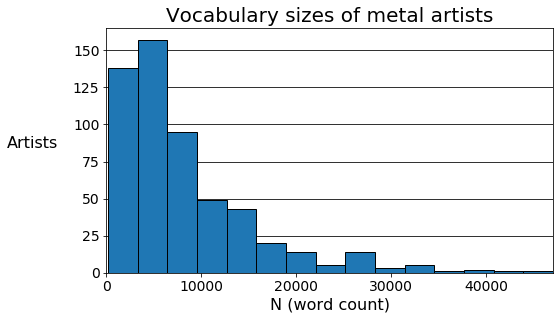

In [14]:
ax = df_bands.N.hist(bins=15, figsize=(8, 4.5), edgecolor='k')
ax.set_xlim(0, df_bands.N.max())
ax.set_title("Vocabulary sizes of metal artists")
ax.set_xlabel("N (word count)")
ax.set_ylabel("Artists", rotation=0, labelpad=40)
ax.grid(None)
ax.grid(axis='y', color='k')
plt.show()

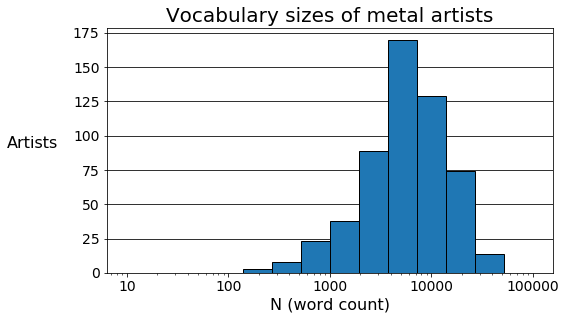

In [15]:
ax = df_bands.N.hist(bins=np.logspace(1, 5, 15), figsize=(8, 4.5), edgecolor='k')
ax.set_xscale('log')
ax.set_title("Vocabulary sizes of metal artists")
ax.set_xlabel("N (word count)")
ax.set_ylabel("Artists", rotation=0, labelpad=40)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.grid(None)
ax.grid(which='major', axis='y', color='k')
ax.grid(which='minor', axis='y', ls=':', alpha=0.6)
plt.show()

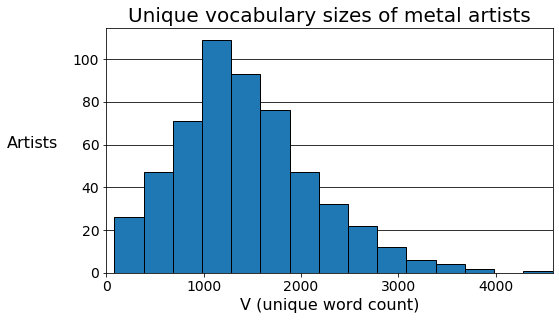

In [16]:
ax = df_bands.V.hist(bins=15, figsize=(8, 4.5), edgecolor='k')
ax.set_xlim(0, df_bands.V.max())
ax.set_title("Unique vocabulary sizes of metal artists")
ax.set_xlabel("V (unique word count)")
ax.set_ylabel("Artists", rotation=0, labelpad=40)
ax.grid(None)
ax.grid(axis='y', color='k')
plt.show()

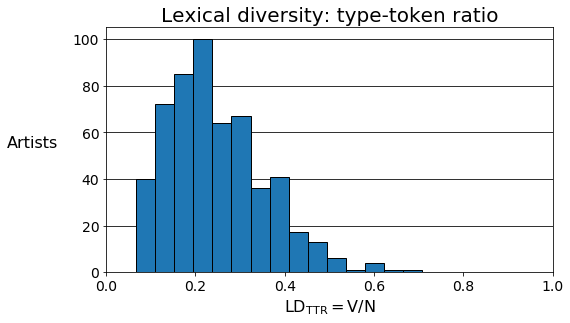

In [17]:
ax = df_bands.TTR.hist(bins=15, figsize=(8, 4.5), edgecolor='k')
ax.set_xlim(0, 1)
ax.set_title("Lexical diversity: type-token ratio")
ax.set_xlabel("$\mathrm{LD_{TTR} = V/N}$")
ax.set_ylabel("Artists", rotation=0, labelpad=40)
ax.grid(None)
ax.grid(axis='y', color='k')
plt.show()

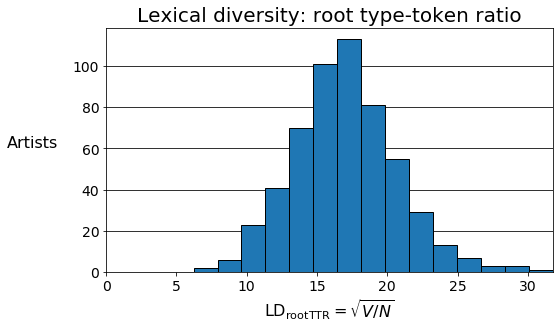

In [18]:
ax = df_bands.rootTTR.hist(bins=15, figsize=(8, 4.5), edgecolor='k')
ax.set_xlim(0, df_bands.rootTTR.max())
ax.set_title("Lexical diversity: root type-token ratio")
ax.set_xlabel("$\mathrm{LD_{rootTTR}} = \sqrt{V/N}$")
ax.set_ylabel("Artists", rotation=0, labelpad=40)
ax.grid(None)
ax.grid(axis='y', color='k')
plt.show()

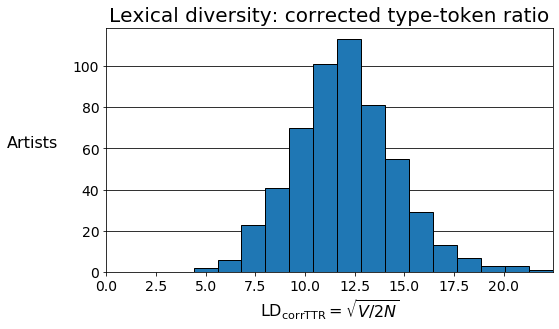

In [19]:
ax = df_bands.corrTTR.hist(bins=15, figsize=(8, 4.5), edgecolor='k')
ax.set_xlim(0, df_bands.corrTTR.max())
ax.set_title("Lexical diversity: corrected type-token ratio")
ax.set_xlabel("$\mathrm{LD_{corrTTR}} = \sqrt{V/2N}$")
ax.set_ylabel("Artists", rotation=0, labelpad=40)
ax.grid(None)
ax.grid(axis='y', color='k')
plt.show()

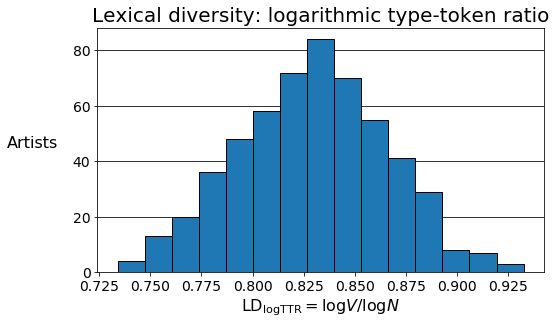

In [20]:
ax = df_bands.logTTR.hist(bins=15, figsize=(8, 4.5), edgecolor='k')
ax.set_title("Lexical diversity: logarithmic type-token ratio")
ax.set_xlabel("$\mathrm{LD_{logTTR}} = \log V / \log N$")
ax.set_ylabel("Artists", rotation=0, labelpad=40)
ax.grid(None)
ax.grid(axis='y', color='k')
plt.show()

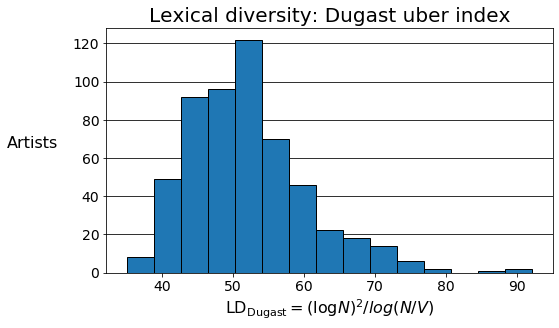

In [21]:
ax = df_bands.dugast.hist(bins=15, figsize=(8, 4.5), edgecolor='k')
ax.set_title("Lexical diversity: Dugast uber index")
ax.set_xlabel("$\mathrm{LD_{Dugast}} = (\log N)^2 / log(N/V)$")
ax.set_ylabel("Artists", rotation=0, labelpad=40)
ax.grid(None)
ax.grid(axis='y', color='k')
plt.show()

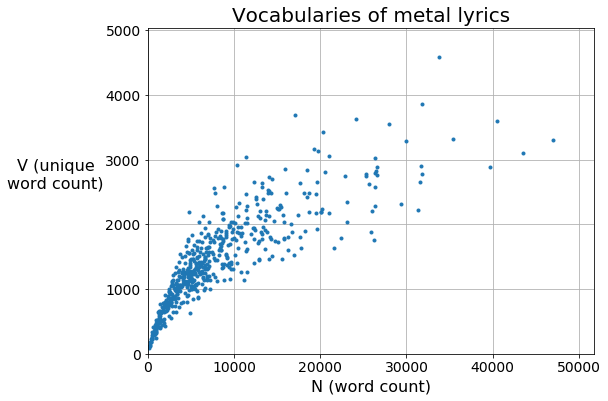

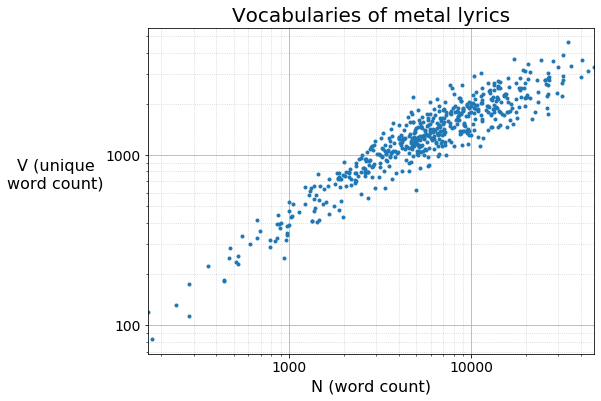

In [22]:
ax = df_bands.plot('N', 'V', lw=0, marker='.', figsize=(8, 6), legend=False)
ax.set_xlim(0, df_bands.N.max() * 1.1)
ax.set_ylim(0, df_bands.V.max() * 1.1)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_xlabel("N (word count)")
ax.set_ylabel("V (unique\nword count)", labelpad=50, rotation=0)
ax.grid(axis='both')
plt.show()

ax = df_bands.plot('N', 'V', lw=0, marker='.', figsize=(8, 6), legend=False)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_xlabel("N (word count)")
ax.set_ylabel("V (unique\nword count)", labelpad=50, rotation=0)
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
plt.show()

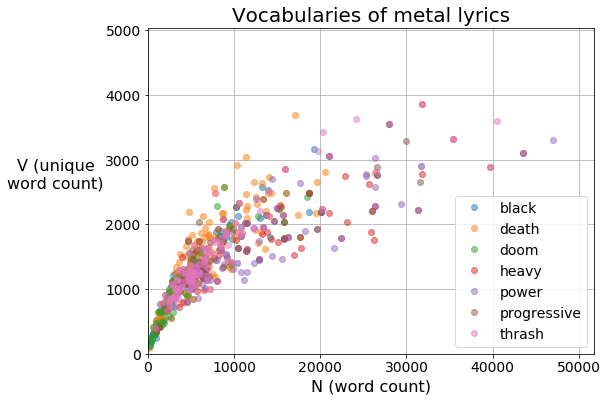

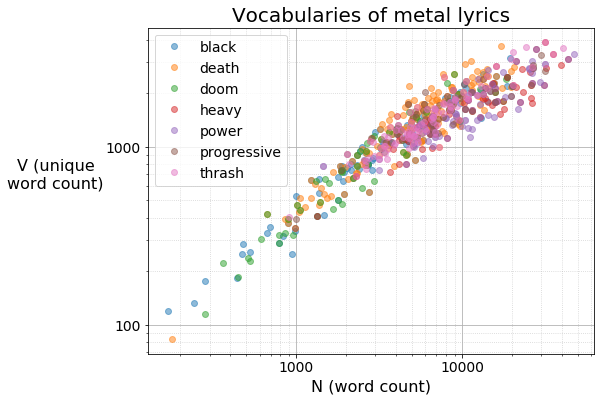

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.V, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xlim(0, df_bands.N.max() * 1.1)
ax.set_ylim(0, df_bands.V.max() * 1.1)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_xlabel("N (word count)")
ax.set_ylabel("V (unique\nword count)", labelpad=50, rotation=0)
ax.grid(axis='both')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.V, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_xlabel("N (word count)")
ax.set_ylabel("V (unique\nword count)", labelpad=50, rotation=0)
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
ax.legend()
plt.show()

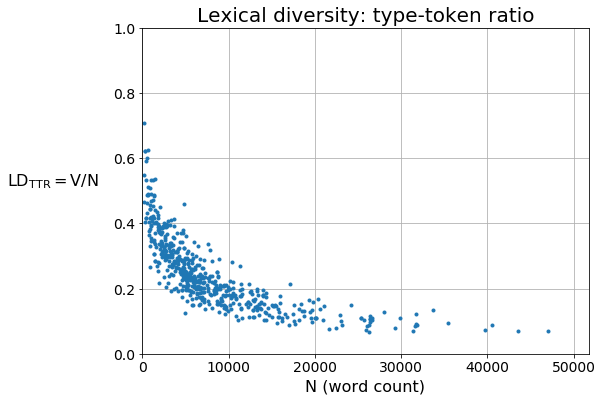

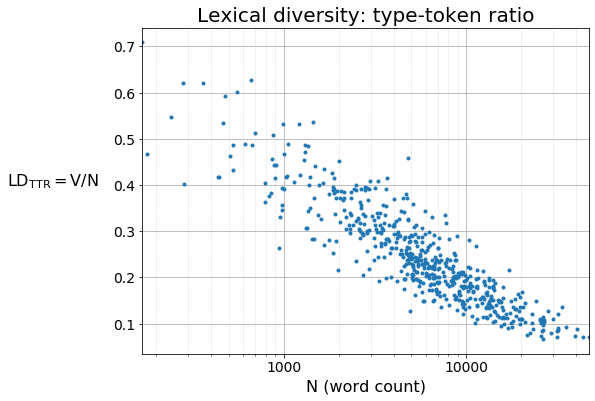

In [24]:
ax = df_bands.plot('N', 'TTR', lw=0, marker='.', figsize=(8, 6), legend=False)
ax.set_xlim(0, df_bands.N.max() * 1.1)
ax.set_ylim(0, 1)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$", labelpad=60, rotation=0)
ax.grid(axis='both')
plt.show()

ax = df_bands.plot('N', 'TTR', lw=0, marker='.', figsize=(8, 6), legend=False)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$", labelpad=60, rotation=0)
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
plt.show()

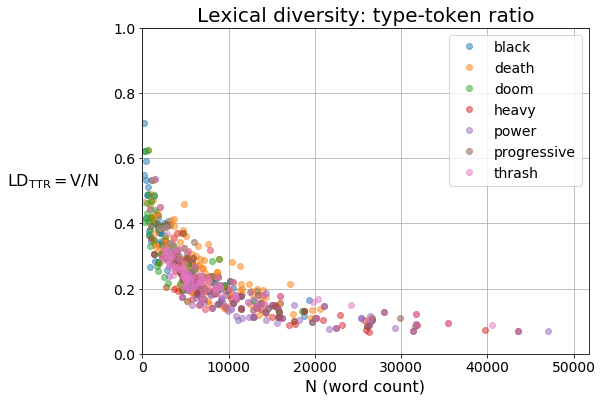

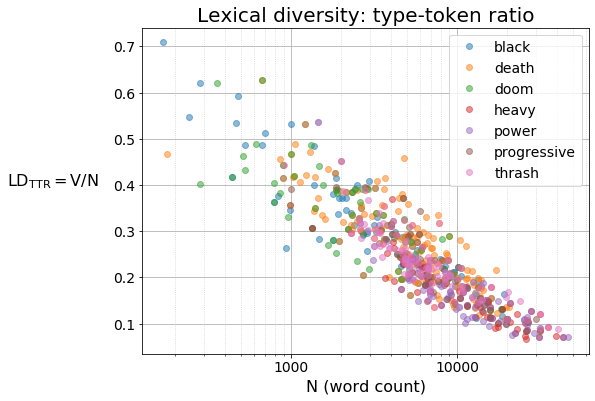

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.TTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xlim(0, df_bands.N.max() * 1.1)
ax.set_ylim(0, 1)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$", labelpad=60, rotation=0)
ax.grid(axis='both')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.TTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$", labelpad=60, rotation=0)
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
ax.legend()
plt.show()

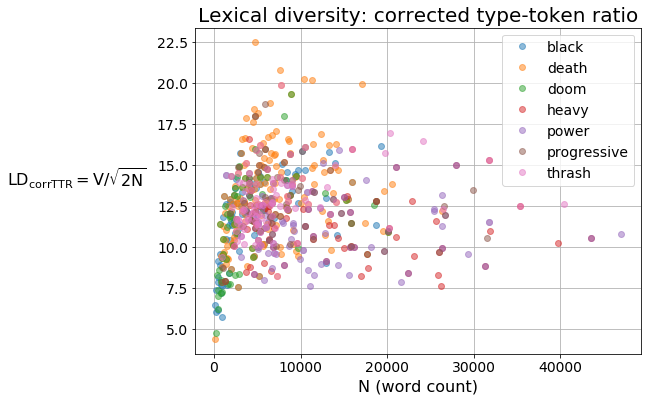

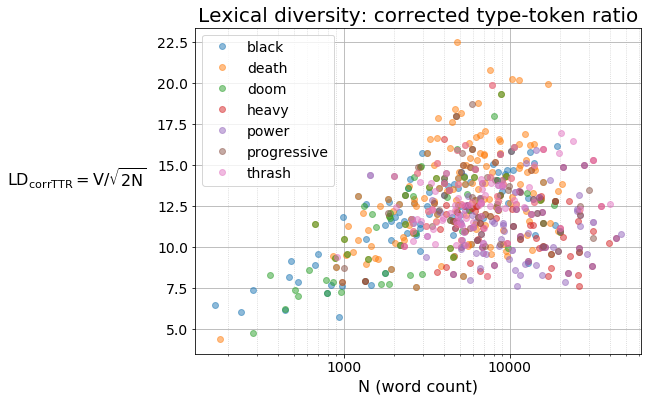

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.corrTTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: corrected type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel("$\mathrm{LD_{corrTTR} = V/\sqrt{2N}}$", labelpad=80, rotation=0)
ax.grid(axis='both')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.corrTTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: corrected type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel("$\mathrm{LD_{corrTTR} = V/\sqrt{2N}}$", labelpad=80, rotation=0)
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
ax.legend()
plt.show()

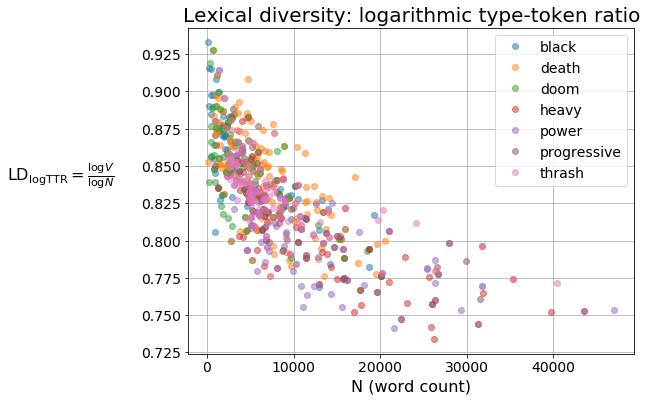

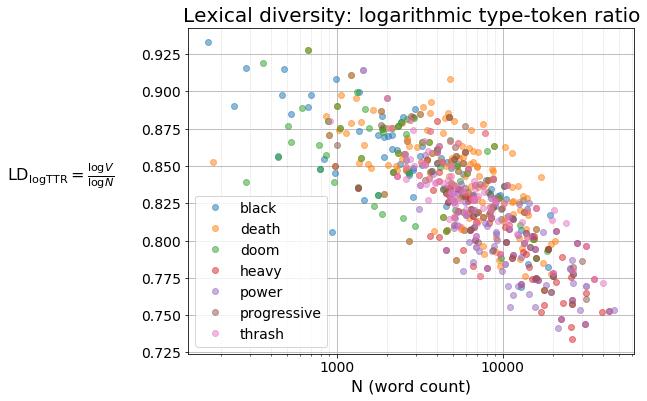

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.logTTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: logarithmic type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$", labelpad=80, rotation=0)
ax.grid(axis='both')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.logTTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: logarithmic type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$", labelpad=80, rotation=0)
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
ax.legend()
plt.show()

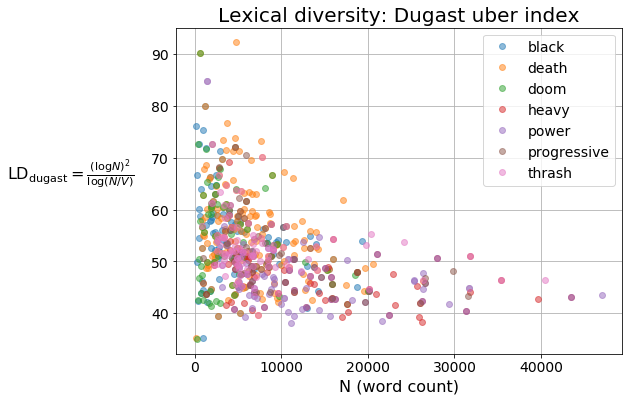

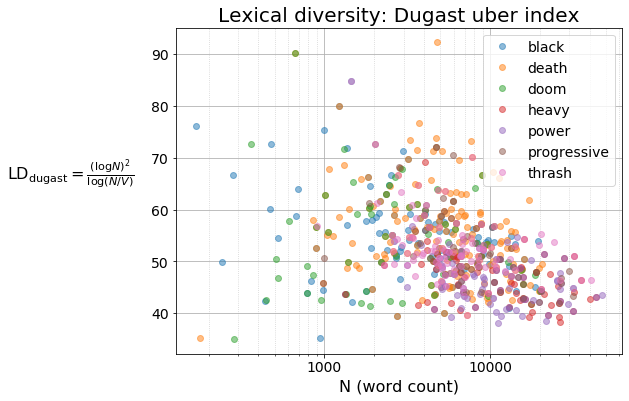

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.dugast, 'o', markeredgewidth=1, alpha=0.5, label=genre)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: Dugast uber index")
ax.set_xlabel("N (word count)")
ax.set_ylabel(r"$\mathrm{LD_{dugast}} = \frac{(\log N)^2}{\log(N/V)}$", labelpad=80, rotation=0)
ax.grid(axis='both')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for genre in top_genres:
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        ax.plot(df_genre.N, df_genre.dugast, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Lexical diversity: Dugast uber index")
ax.set_xlabel("N (word count)")
ax.set_ylabel(r"$\mathrm{LD_{dugast}} = \frac{(\log N)^2}{\log(N/V)}$", labelpad=80, rotation=0)
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
ax.legend()
plt.show()

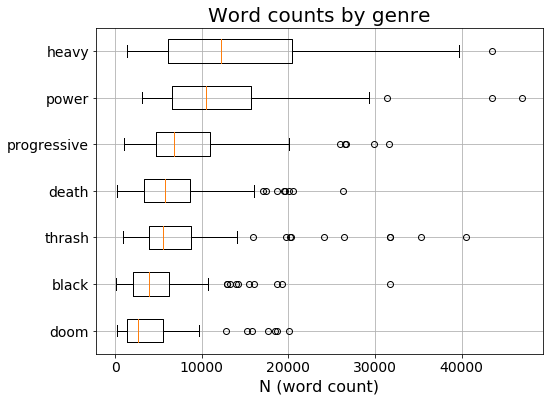

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
boxdata = []
for i, genre in enumerate(top_genres):
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        boxdata.append((genre, df_genre.N))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata])
ax.set_title("Word counts by genre")
ax.set_xlabel("N (word count)")
ax.grid(axis='both')
plt.show()

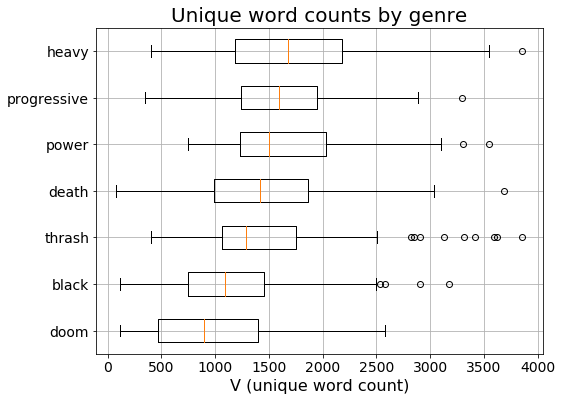

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
boxdata = []
for i, genre in enumerate(top_genres):
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        boxdata.append((genre, df_genre.V))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata])
ax.set_title("Unique word counts by genre")
ax.set_xlabel("V (unique word count)")
ax.grid(axis='both')
plt.show()

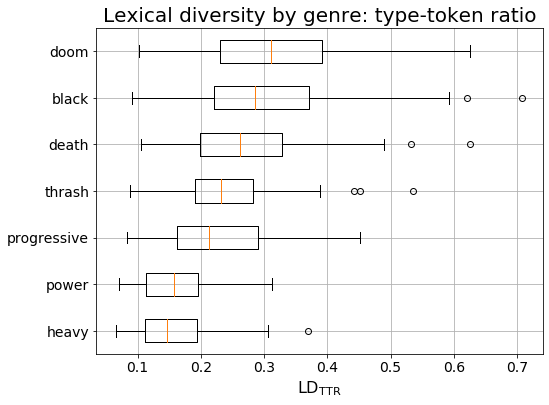

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
boxdata = []
for i, genre in enumerate(top_genres):
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata])
ax.set_title("Lexical diversity by genre: type-token ratio")
ax.set_xlabel("$\mathrm{LD_{TTR}}$")
ax.grid(axis='both')
plt.show()

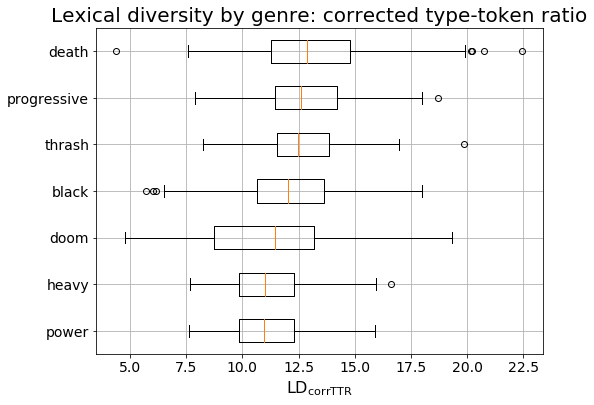

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
boxdata = []
for i, genre in enumerate(top_genres):
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        boxdata.append((genre, df_genre.corrTTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata])
ax.set_title("Lexical diversity by genre: corrected type-token ratio")
ax.set_xlabel("$\mathrm{LD_{corrTTR}}$")
ax.grid(axis='both')
plt.show()

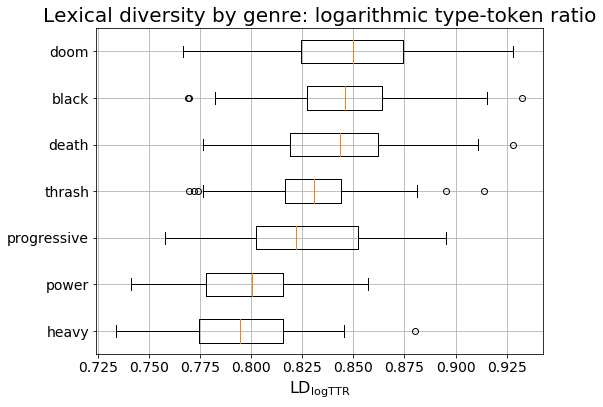

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
boxdata = []
for i, genre in enumerate(top_genres):
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        boxdata.append((genre, df_genre.logTTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata])
ax.set_title("Lexical diversity by genre: logarithmic type-token ratio")
ax.set_xlabel("$\mathrm{LD_{logTTR}}$")
ax.grid(axis='both')
plt.show()

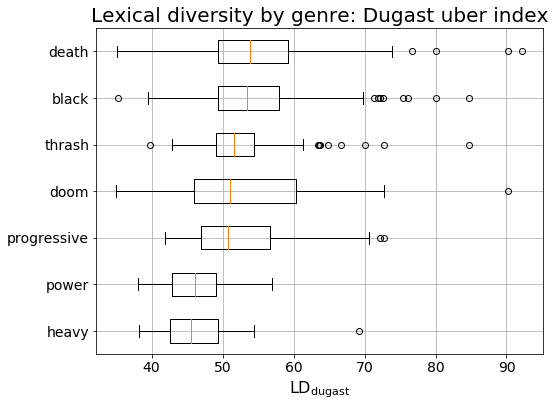

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
boxdata = []
for i, genre in enumerate(top_genres):
    df_genre = df_bands[df_bands['genre_' + genre] == 1]
    if df_genre.shape[0] > 50:
        boxdata.append((genre, df_genre.dugast))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata])
ax.set_title("Lexical diversity by genre: Dugast uber index")
ax.set_xlabel("$\mathrm{LD_{dugast}}$")
ax.grid(axis='both')
plt.show()